Bayesain Logistic Regression using JAX

In [3]:
import os
import pathlib
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from multiprocessing import Pool
import psutil
from climatenet.utils.data import ClimateDataset
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events
import torch
from os import path
from sklearn.metrics import jaccard_score
from climatenet.procrustes_loss import ProcrustesLoss
import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


config = Config('/home/sbk29/data/ClimateNet/config.json')
model = CGNet(config)

In [37]:
from torch.utils.data import Dataset, DataLoader
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
model = CGNet(config)
labeled_dataset_test = ClimateDatasetLabeled('/home/sbk29/data/AR/test', model.config)
labeled_dataset_val = ClimateDatasetLabeled('/home/sbk29/data/AR/validation', model.config)
labeled_dataset_test_val = ClimateDatasetLabeled('/home/sbk29/data/AR/test_val', model.config)

test_val_loader = DataLoader(labeled_dataset_test_val, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
test_loader = DataLoader(labeled_dataset_test, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
val_loader = DataLoader(labeled_dataset_val, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
true_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(test_val_loader):
    true_mask.append(labels)
true_mask = np.array(true_mask)

In [ ]:
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
# cgnet = CGNet(config)

train_path = '/home/sbk29/data/AR/'
train_dataset = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
model.train(train_dataset)

In [38]:
training_set = ClimateDatasetLabeled('/home/sbk29/data/AR/train', model.config)
inference_set = ClimateDataset('/home/sbk29/data/AR/test_val', model.config)
test_set = ClimateDataset('/home/sbk29/data/AR/test', model.config)

# Load the model

model.load_model(weight_path = '/home/sbk29/data/github_AR/AR_detection/climatenet/weights/weights_CE.pth', config_path = "/home/sbk29/data/github_AR/AR_detection/climatenet/weights/config_new.json")

In [39]:
test_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(test_loader):
    test_mask.append(labels)

test_mask = np.array(test_mask)

In [40]:
predictions_test = model.predict(test_set)
predictions = model.predict(inference_set)

 25%|██▌       | 1/4 [00:00<00:02,  1.05it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 2/4 [00:01<00:01,  1.11it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 3/4 [00:02<00:00,  1.24it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Output shape : torch.Size([7, 2, 768, 1152])
(7, 2, 768, 1152)


 12%|█▎        | 1/8 [00:00<00:04,  1.72it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 25%|██▌       | 2/8 [00:01<00:03,  1.73it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 38%|███▊      | 3/8 [00:01<00:02,  1.70it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 4/8 [00:02<00:02,  1.67it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 62%|██████▎   | 5/8 [00:03<00:02,  1.36it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 6/8 [00:04<00:01,  1.38it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 88%|████████▊ | 7/8 [00:04<00:00,  1.43it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

Output shape : torch.Size([5, 2, 768, 1152])
(5, 2, 768, 1152)


In [41]:
predictions = np.array(predictions)
predictions_test = np.array(predictions_test)

In [42]:
from scipy.special import softmax
predictions_softmax = softmax(predictions, axis=1) # shape (61, 2, 768, 1152)

In [43]:
score_whole = (predictions[:, 1] - predictions[:, 0])
score_whole = np.array(score_whole)

In [44]:
score = (predictions_test[:, 1] - predictions_test[:, 0])
score = np.array(score)

In [45]:
z_test = score.reshape(-1)          # (N·H·W,)
y_test = test_mask.reshape(-1)          # same length

In [46]:
N, H, W = score.shape

JAX implementation of Bayesian Logistic Regression

In [47]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# 1) Send your data to the GPU
#    z: logits, shape (Npix,)
#    y: labels 0/1, same shape
z_flat = jnp.asarray(z_test.astype("float32"))
y_flat = jnp.asarray(y_test.astype("int32"))

# 2) Define the Platt‐scaling model
def platt_model(z, y=None):
    A = numpyro.sample("A", dist.Normal(0.0, 10.0))
    B = numpyro.sample("B", dist.Normal(0.0, 10.0))
    logits = A * z + B
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        
# 3) Set up and run NUTS on the GPU
kernel = NUTS(platt_model, target_accept_prob=0.9)
mcmc   = MCMC(kernel, num_warmup=1500, num_samples=1500, num_chains=2)
rng_key = jax.random.PRNGKey(0)

mcmc.run(rng_key, z=z_flat, y=y_flat)
mcmc.print_summary()   # shows mean, sd, R-hat, ESS for A and B

# 4) Extract posterior samples of A, B
posterior = mcmc.get_samples()
A_draws   = posterior["A"]   # shape (1000,)
B_draws   = posterior["B"]

/tmp/ipykernel_2674595/483609228.py:23: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc   = MCMC(kernel, num_warmup=1500, num_samples=1500, num_chains=2)
sample: 100%|██████████| 3000/3000 [00:38<00:00, 76.96it/s, 7 steps of size 1.38e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.87      0.00      0.87      0.87      0.88   1531.09      1.00
         B     -0.28      0.00     -0.28     -0.28     -0.28    933.37      1.00

Number of divergences: 0


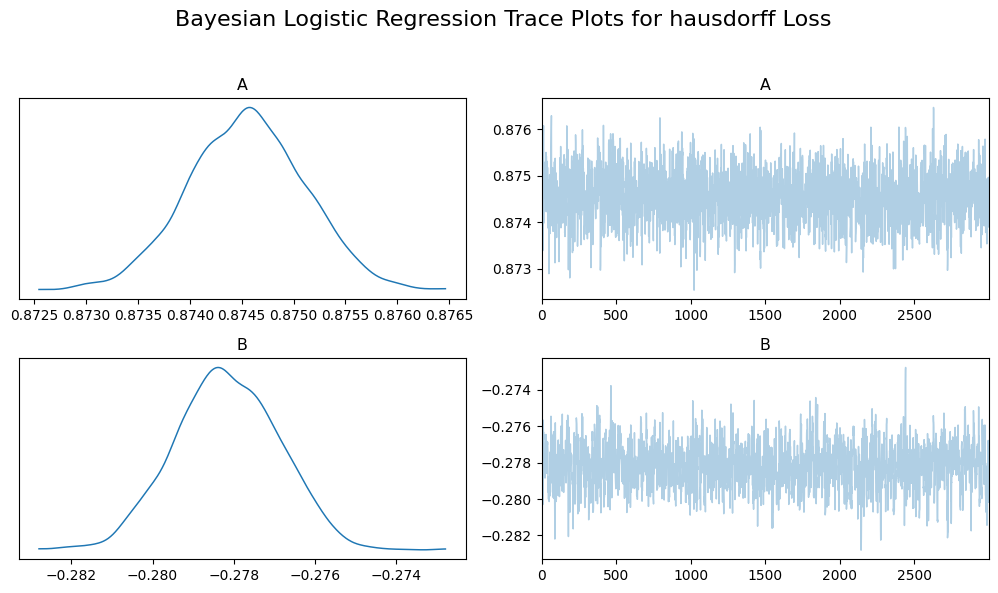

In [ ]:
# 1) Extract posterior draws from your MCMC object
posterior = mcmc.get_samples()    # these are JAX DeviceArrays on GPU

# 2) Move A and B to NumPy on the host
A_np = np.asarray(posterior["A"])  # shape (n_samples,)
B_np = np.asarray(posterior["B"])

# 3) Create an ArviZ InferenceData from a Python dict
idata = az.from_dict(posterior={"A": A_np, "B": B_np})

# 4) Plot the trace
axes = az.plot_trace(idata, var_names=["A", "B"], figsize=(10, 6))

# 5) Add a super‐title and tighten layout
plt.suptitle("Bayesian Logistic Regression Trace Plots for Cross Entropy Loss", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [49]:
A_hat = np.mean(A_np)
B_hat = np.mean(B_np)

In [50]:
p_hat = 1/(1 + np.exp(-(A_hat * z_test + B_hat)))

In [51]:
p_hat = p_hat.reshape(N,H,W)

In [52]:
# Compute the 2.5 and 97.5 percentiles
A_low, A_high = np.percentile(A_np, [2.5, 97.5])
B_low, B_high = np.percentile(B_np, [2.5, 97.5])

In [53]:
p_low = 1/ (1 + np.exp(-(A_low * z_test + B_low)))
p_high = 1/ (1 + np.exp(-(A_high * z_test + B_high)))
p_low = p_low.reshape(N,H,W)
p_high = p_high.reshape(N,H,W)

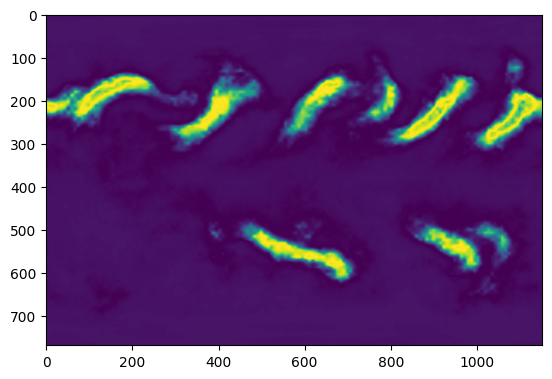

In [54]:
plt.imshow(p_high[0,:,:]-p_hat[0,:,:])

In [55]:
val_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(val_loader):
    val_mask.append(labels)
val_mask = np.array(val_mask)

In [56]:
validation_set = ClimateDataset('/home/sbk29/data/AR/validation', model.config)
predictions_val = model.predict(validation_set)
print(predictions_val.shape)
predictions_val = np.array(predictions_val)

 25%|██▌       | 1/4 [00:00<00:02,  1.13it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 2/4 [00:01<00:01,  1.34it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 3/4 [00:02<00:00,  1.48it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

Output shape : torch.Size([6, 2, 768, 1152])
(6, 2, 768, 1152)
(30, 2, 768, 1152)


In [57]:
scores_val = predictions_val[:, 1] - predictions_val[:,0]
z_val = scores_val.reshape(-1)    
y_val = val_mask.reshape(-1)  

(26542080,)


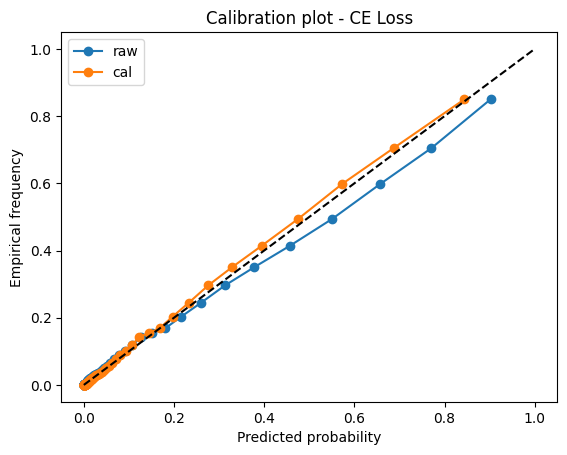

In [59]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# flatten again
p_raw = 1/(1+np.exp(-z_val))    # uncalibrated sigmoid
p_cal = 1 / (1 + np.exp(-(A_hat * z_val + B_hat))) 
p_cal = np.array(p_cal)  
print(p_cal.shape)
p_cal_flat = p_cal.reshape(-1)
# print("Brier before:", brier_score_loss(y, p_raw))
# print("Brier after :", brier_score_loss(y, p_cal_flat))

# reliability diagram
for name, p in {"raw":p_raw, "cal":p_cal_flat}.items():
    frac_pos, mean_pred = calibration_curve(y_val, p, n_bins=100, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.title("Calibration plot - CE Loss")
plt.show()

In [60]:
N, Batch, H, W = val_mask.shape

In [61]:
p_low = 1/ (1 + np.exp(-(A_low * z_val + B_low)))
p_high = 1/ (1 + np.exp(-(A_high * z_val + B_high)))
p_low = p_low.reshape(N,H,W)
p_high = p_high.reshape(N,H,W)

P CAL

In [65]:
p_cal = p_cal.reshape(N,H,W)
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_cal = p_cal>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.3423320633489014


P LOW

In [27]:

# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_cal = p_low>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.31362006249844077


P HIGH

In [28]:

# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_cal = p_high>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.31447086341250496


P RAW

In [66]:
p_raw = 1/(1 + np.exp(-scores_val))
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = val_mask.shape[0]
scores = []
predicted_mask_cal = p_raw>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = val_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.37438834534090876


In [59]:
scores_val.shape

(30, 768, 1152)

In [ ]:
plt.imshow()

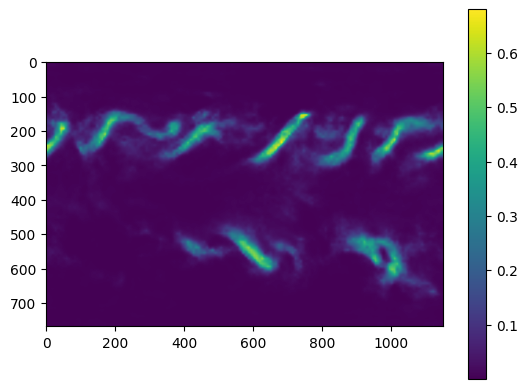

In [55]:
plt.imshow(predictions_softmax[1,1,:,:])
plt.colorbar()

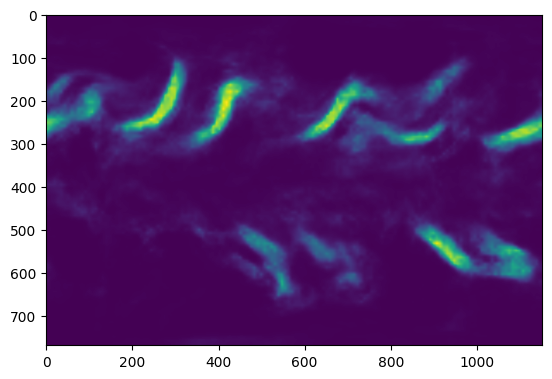

In [54]:
plt.imshow(1/(1 + np.exp(-scores_val[1,:,:])))

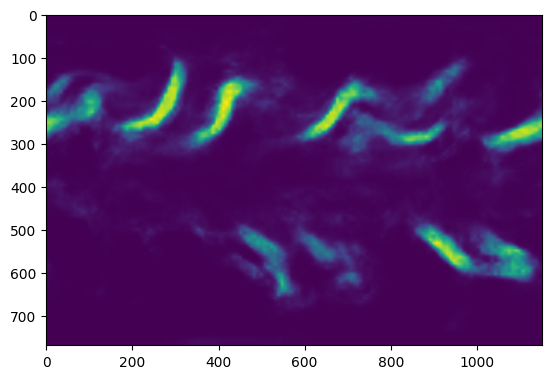

In [53]:
plt.imshow(p_cal[1,:,:])

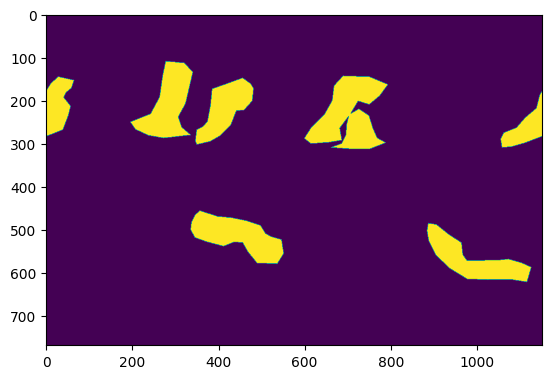

In [31]:
plt.imshow(val_mask[1,0,:,:])

In [67]:
import numpy as np
from typing import Tuple, Literal, Union

try:
    import torch
    _has_torch = True
except ImportError:
    _has_torch = False

Array = Union[np.ndarray, "torch.Tensor"]  # forward ref for typing

def fp_fn_percent(true_mask: Array,
                  pred_mask: Array,
                  reduction: Literal["image", "dataset"] = "image"
                 ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the percentage of false-positive (FP) and false-negative (FN)
    pixels between *binary* true and predicted masks.

    Parameters
    ----------
    true_mask  : ndarray or torch.Tensor, shape (N, H, W) or (H, W)
        Ground-truth labels (0 / 1 or False / True).
    pred_mask  : ndarray or torch.Tensor, same shape as true_mask
        Predicted labels (0 / 1 or False / True).
    reduction  : "image" | "dataset", default "image"
        • "image"   – return %FP and %FN **per image** (length N).
        • "dataset" – return a single %FP and %FN over all pixels.

    Returns
    -------
    fp_pct, fn_pct : numpy.ndarray | float
        Percentages of FP and FN pixels (0 → 100).
    """
    # --- unify to numpy for easy maths --------------------------------------
    if _has_torch and torch.is_tensor(true_mask):
        true_mask = true_mask.cpu().numpy()
    if _has_torch and torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()

    if true_mask.shape != pred_mask.shape:
        raise ValueError("true_mask and pred_mask must have the same shape")

    # Ensure boolean dtype
    true_mask = true_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)

    fp =  pred_mask & ~true_mask          # False-positive pixels
    fn = ~pred_mask &  true_mask          # False-negative pixels

    if true_mask.ndim == 2:               # single image → add batch dim
        fp = fp[None, ...]
        fn = fn[None, ...]
    N, H, W = fp.shape

    if reduction == "image":
        total = H * W
        fp_pct = fp.reshape(N, -1).mean(axis=1) * 100.0   # (N,)
        fn_pct = fn.reshape(N, -1).mean(axis=1) * 100.0
    elif reduction == "dataset":
        total = N * H * W
        fp_pct = fp.sum() / total * 100.0                 # scalar
        fn_pct = fn.sum() / total * 100.0
    else:
        raise ValueError("reduction must be 'image' or 'dataset'")

    return fp_pct, fn_pct


In [68]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = val_mask[:,0]               # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (p_raw > 0.5 )                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (30, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
print("False-positive % per image:", fp_pct)
print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

False-positive % per image: [0.78893591 0.03616898 3.0412462  0.88975694 1.08665184 1.05862088
 1.06009024 1.46891276 2.45824743 0.78633626 0.75807925 1.53774685
 0.45346861 0.63860858 0.71818034 1.87061451 1.3550935  0.6366871
 1.80584943 1.59516511 2.37098976 0.56909632 1.55334473 2.21037688
 3.1994855  1.83727123 2.37935384 0.76463487 0.35163032 1.55549226]
False-negative % per image: [2.21512406 6.38032136 1.60827637 5.77471698 2.09746184 2.22111455
 3.76846879 2.73900915 1.70808015 4.19684516 4.05669036 2.69447609
 4.79487666 4.80957031 4.22476309 2.26203071 2.66881872 2.91770652
 1.60578975 1.2061225  2.05552843 5.00341345 2.14165582 2.73753979
 0.81244575 3.37083605 1.43850821 2.01302988 5.42206941 2.5197347 ]
Whole dataset  —  FP: 1.36 %,  FN: 3.05 %


P- CAL 

In [69]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = val_mask[:,0]               # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (p_cal > 0.5 )                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (30, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
print("False-positive % per image:", fp_pct)
print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

False-positive % per image: [0.44431333 0.00553838 2.43010344 0.53179706 0.66189236 0.78554507
 0.64075611 0.91484918 1.74730089 0.41526512 0.40283203 1.01985225
 0.29737684 0.41978624 0.49280237 1.3708044  1.03330259 0.30777543
 1.18882921 1.03511104 1.72175655 0.35309968 1.16396304 1.71508789
 2.47045446 1.30016186 1.83749729 0.52625868 0.22402163 1.09501591]
False-negative % per image: [2.65186451 6.85684769 1.80223253 6.22185601 2.47780129 2.49701606
 4.34366862 3.17947953 1.94939507 4.6009205  4.47658963 2.95172797
 5.35153989 5.30350297 4.80211046 2.56494593 3.14975315 3.4233941
 1.82336878 1.51932328 2.27955006 5.66067166 2.3779975  3.10635037
 0.94751429 3.68618435 1.74910934 2.38116229 5.90096933 2.87181713]
Whole dataset  —  FP: 0.95 %,  FN: 3.43 %


P - LOW

In [73]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = val_mask[:,0]               # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (p_low > 0.5 )                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (30, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
# print("False-positive % per image:", fp_pct)
# print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

Whole dataset  —  FP: 0.95 %,  FN: 3.43 %


P - HIGH

In [72]:
# ---------------------------- raw arrays you have ---------------------------
# pred_mask : shape (31, 768, 1152)          dtype int/float/bool
# true_mask : shape (31, 2, 768, 1152)       one-hot

# ----------------- 1) collapse one-hot gt → single-channel binary ------------
# Option A: just take the foreground channel (class-1)
gt_bin = val_mask[:,0]               # shape (31, 768, 1152)
# Option B (generic): gt_bin = true_mask.argmax(axis=1)

# ----------------- 2) make sure both are boolean -----------------------------
pred_bin = (p_high > 0.5 )                   # in case it is 0/1 ints
gt_bin   = gt_bin.astype(bool)

assert pred_bin.shape == gt_bin.shape == (30, 768, 1152)

# ----------------- 3) compute percentages ------------------------------------
fp_pct, fn_pct = fp_fn_percent(gt_bin, pred_bin, reduction="image")
# print("False-positive % per image:", fp_pct)
# print("False-negative % per image:", fn_pct)

# ------ if you prefer a single dataset-wide number ---------------------------
fp_all, fn_all = fp_fn_percent(gt_bin, pred_bin, reduction="dataset")
print(f"Whole dataset  —  FP: {fp_all:.2f} %,  FN: {fn_all:.2f} %")

Whole dataset  —  FP: 0.96 %,  FN: 3.43 %


In [44]:
procrustes_loss_fn = ProcrustesLoss(
        threshold=0.5, allow_scaling=False, penalty_constant=500
    )

In [65]:
from scipy.special import softmax

In [66]:
val_mask_tensor = torch.tensor(val_mask[:,0,:,:])
predictions_val = softmax(predictions_val, axis=1)
predictions_val = torch.tensor(predictions_val) # It has to be N,B,H,W

In [67]:
predictions_val.shape

torch.Size([30, 2, 768, 1152])

In [64]:
p_raw = 1/(1 + np.exp(-score_whole))
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []
predicted_mask_cal = p_raw>0.5
for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask_cal[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.3659430034620526
